# 1. Exploring the housing dataset

• CRIM: Per capita crime rate by town

• ZN: Proportion of residential land zoned for lots over 25,000 sq. ft.

• INDUS: Proportion of non-retail business acres per town

• CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

• NOX: Nitric oxide concentration (parts per 10 million)

• RM: Average number of rooms per dwelling

• AGE: Proportion of owner-occupied units built prior to 1940

• DIS: Weighted distances to five Boston employment centers

• RAD: Index of accessibility to radial highways

• TAX: Full-value property tax rate per $10,000

• PTRATIO: Pupil-teacher ratio by town

• B: 1000(Bk - 0.63)^2, where Bk is the proportion of [people of African
American descent] by town

• LSTAT: Percentage of lower status of the population

• MEDV: Median value of owner-occupied homes in $1000s


In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch10/housing.data.txt', header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
              'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


/home/barto/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


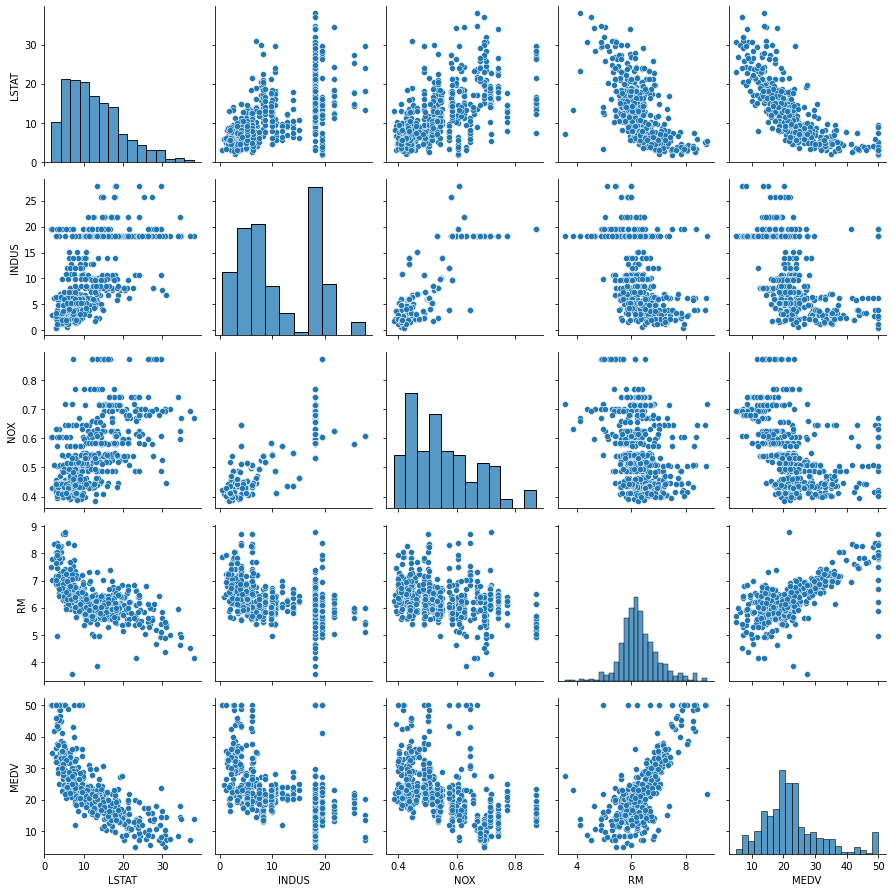

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)

plt.tight_layout()
plt.show()

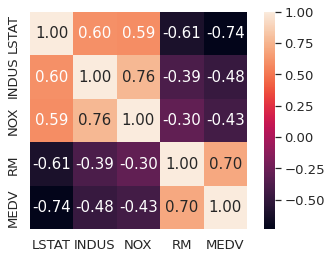

In [10]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

# 2. Implementing linear regression

In [12]:
# implementing linear regression using gradient descent

class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)
    

In [18]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

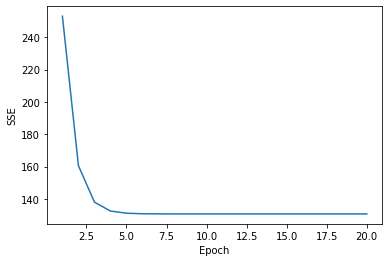

In [20]:
sns.reset_orig() #resets matplotlib style
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [21]:
# helper function to plot the training samples and the regression line
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

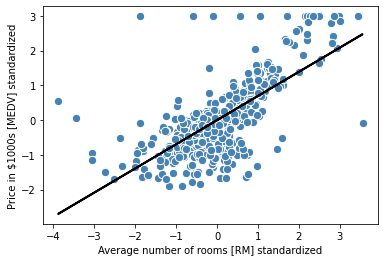

In [22]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] standardized')
plt.ylabel('Price in $1000s [MEDV] standardized')
plt.show()

In [34]:
num_rooms_std = sc_x.transform(np.array(5.0).reshape(1, -1))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std.reshape(1, -1)))

Price in $1000s: 10.840


In [36]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0]) # we don't have to compute w0 if we use standardized data

Slope: 0.695
Intercept: -0.000


# 3. Regression model via scikit-learn

In [37]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept %.3f' % slr.intercept_)

Slope: 9.102
Intercept -34.671


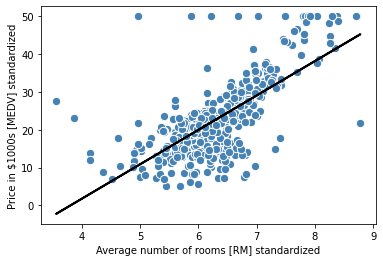

In [38]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM] standardized')
plt.ylabel('Price in $1000s [MEDV] standardized')
plt.show()

# 4. RANSAC

In [40]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, y)

/home/barto/.local/lib/python3.8/site-packages/sklearn/linear_model/_ransac.py:354: FutureWarning: The loss 'absolute_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='absolute_error'` which is equivalent.
  warnings.warn(


RANSACRegressor(base_estimator=LinearRegression(), loss='absolute_loss',
                min_samples=50, random_state=0, residual_threshold=5.0)

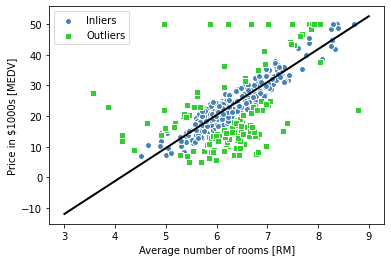

In [41]:
# let's visualize inliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask], 
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], 
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')

plt.plot(line_X, line_y_ransac, color='black', lw=2)

plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [45]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept -44.089
